<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

The dynamics is shown to be line atttractors.  But how this attractor is used?  What is relation between them and real game dynamics?  

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

# import pretrain
# from pretrain import *

import pandas as pd

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import Nets 
from Nets import *

import dynamics
from dynamics import * 

# import GLM
# from GLM import *

from mpl_toolkits.mplot3d import Axes3D  

%pylab inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Pretrained network
Record the relaxation to line attractor by setting on the averaged action for different steps(T=2 for initially, T=100 for more.

How much variance is caused action, how much is caused by action itself? 

Measure velocity with null actions and with full actions, compare the velocity caused by action and remaing velocity,  it might reveals the dh/dt = ah + bA with a and b measured.   

If with null action speed not goes to 0, think how the given dynamical structures gives the position components, does it still effective to say that with action is fast direction, null action is slow direction

In [9]:
class slowmanifold():
    def __init__(self, weight):
        self.weight = weight
        self.pca = PCA(weight = self.weight)
        
    def Simulations(self, k_action = 1, epsilon = 0, size = 15, T = 200, seed_num = 1e3, reward_control = None):
        PC_traces = []
        Hiddens = []
        Poss = []
        Actions = []
        States = []
        Context = []
        for i in range(T):
            torch.manual_seed(np.random.randint(seed_num))
            hidden0 = torch.randn(1, 512)
            if reward_control == None:
                c  = np.random.randint(2)
            else:
                c = reward_control
            start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
            game = CreateGame(GameBasic, holes = 0)
            game.net.load_state_dict(torch.load(self.weight))
            game.net.k_action = k_action 
            grid = game.grid.grid.copy()
            Pos, hidden, dh, Action, State, reward = trajectory(game, start, reward_control = c, size = size, \
                                                                      test = 0, limit_set = 4, init_hidden = False, hidden = hidden0, epsilon = epsilon)
            Hiddens.append(hidden)
            Poss.append(Pos[1:])
            Actions.append(Action)
            States.append(State)
            Context.append(c * np.ones(len(State)))
        return States, Poss, Hiddens, Actions, Context   
    
    def Transform(self, States, Poss, Hiddens, Actions, Context, 
                  history = False, stages = False, size = 15):
    # last click state
        Status = np.concatenate([State_transform(state, poss, size) for state, poss in zip(States, Poss)])
        Stages = np.concatenate([Stage_transform(state) for state in States])
        Hiddens = np.concatenate(Hiddens)
        Poss = np.concatenate(Poss)
        Actions = np.concatenate(Actions)
        Context = np.concatenate(Context)
        # transform state to stim　
        States = np.concatenate(States)
        # transform status to memory
        Memory = history_summary(Status)
        set_ = set([tuple(s) for s in States])
        dict_ = {}
        for i, s in enumerate(set_): 
            dict_.update({s:i})
        Stim = [dict_[tuple(s)] for s in States] 
        set_ = set([tuple(m) for m in Memory])
    #     dict_ = {}
    #     for i, m in enumerate(set_): 
    #         dict_.update({m:i})
    #     Mem = [dict_[tuple(m)] for m in Memory] 
        return Stages, States, Poss, Hiddens, Actions, Status, Context, Memory 

        
    def pca_record(self):
        self.pca.pca()
        
    def data_record(self, epsilon = 0.5, T = 500):
        States, Poss, Hiddens, Actions, Context = self.Simulations(k_action = 1, epsilon = epsilon, size = 15, T = T, seed_num = 1e3, reward_control = 0)
        Stages, States, Poss, Hiddens, Actions, Status, Context, Memory = self.Transform(States, Poss, Hiddens, Actions, Context, stages = True, size = 15)
        self.States = States
        self.Poss = Poss
        self.Hiddens = Hiddens
        self.Actions = Actions
        self.Status = Status
        self.Context = Context
        self.Memory = Memory 
        self.Stages = Stages
        
    def manifold_record(self, T_slow = 5):
#         Hiddens0 = self.Hiddens[self.Status == status]
        Hidden1 = []
        Hiddens1 = []
        Velocity0 = []
        Velocity1 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c, a in zip(self.Hiddens, self.Context, self.Actions):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            hidden0 = self.pca.relaxation(T = T_slow, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity1.append(velocity)
            Hidden1.append(hidden0)
            Hiddens1.append(self.pca.Hiddens)
        Hidden1 = np.array(Hidden1)
        Hiddens1 = np.array(Hiddens1)
        return Hidden1, Hiddens1
    
    def gradientdescent(self, hidden0, stim = torch.zeros(1, 9) , action = 4, iterations = 1):
        for i in range(int(iterations * 1e2)+1):
            hidden0 = Variable(hidden0,requires_grad=True)
            velocity = fixpoints(weight, hidden0, stim = stim, action = action)
            if i%500 == 0:
                print (i, velocity)
        #     print (hidden0.requires_grad)
            velocity.backward()
        #     print ('grad0', hidden0.grad[0][0])
            hidden0 = torch.add(hidden0, -1e-2 * (hidden0.grad))
            hidden0 = Variable(hidden0,requires_grad=True)
        return hidden0, velocity

    

### Starting from random 

**color the slow manifold by stimulus memory and position, if the ring-like manifold corresponding to any structure**

# PosNet

## color the state space according to memory state, past history
Until now it seems the hidden states only record single history of last stimlus, which is reflected in line attractor behavoiur, which in constrast to claim of 2 clicks, It is well noticing the intrinsic manifold depending on exploration noise.  

Little noise limit, with noised increase , the intrinsic manifold dimension will increases, but it is never larger than the 2 for the slow relaxation and 3 for real state   

In [11]:
weight = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(399)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2,  Hiddens2 = manifold.manifold_record(T_slow = 50)


Hiddens2 = Hiddens2.transpose(1, 0 ,2)

IndexError: index 50 is out of bounds for axis 1 with size 50

In [10]:
## calculate participation ratio

Cor = np.zeros((512, 512))
for h in Hiddens2[-1]:
    h = (h - np.mean(h))/np.std(h)
    h = h.reshape(1, 512)
    Cor += h.T @ h 
print (Cor)
lambdas, vs = np.linalg.eig(Cor)
np.sum(lambdas) ** 2/np.sum(lambdas** 2)

NameError: name 'Hiddens2' is not defined

Study the relation between hidden states space and encoded variable x, y, s. As h can be represented by PC1-3 , then we need to find a function that goes from PC = f(x, y, s) also x, y, s = g(PC0,PC1, PC2)for both hidden states.  

In this analysis, I find about this structure in the following manner:  

Record all PCs for a lot of hidden state with their variables, do a supervised learnign as GLM with it.  Then use it to predict the real trajectories coordinates,  see if hte slow skelonton explains both encoding, decoding  

Because of the sliding,we cannot directly mapping the real state x , y to relaxed hidden states , they are not colliding together, another way of parameterisation need to be thought ,such as topology,  or order, or nearest neibours 

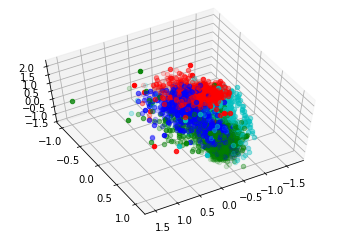

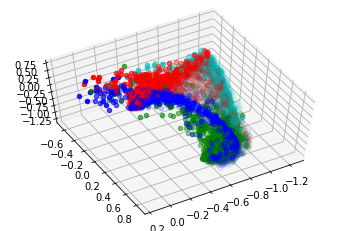

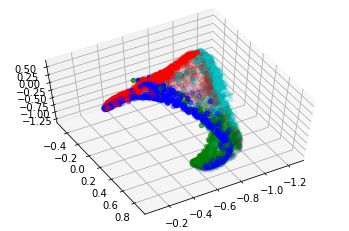

In [7]:
# colored by velocity,  which indicates the border 
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(60, 60)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
#         ax.scatter(Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[0], Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[1],
#                    Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 1, marker = 's', s = 80)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for k in [1, 2, 3, 4]:
#     V = np.array(Velocity0)[manifold.Status == k]
#     V = [v.data.numpy().item() for v in V]
    
#     for i, hidden in enumerate(Hidden2[manifold.Status == k]):
#         ax.view_init(60, 60)
#         ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
#                    hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)

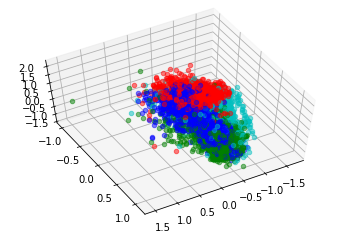

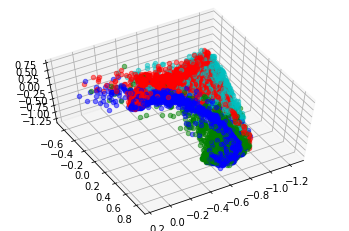

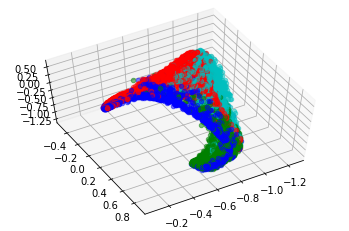

In [13]:
# no coloring on velocity   
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(60, 60)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)

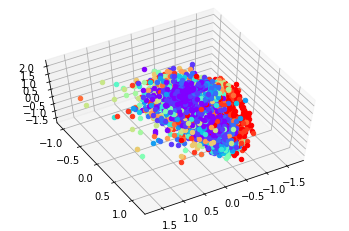

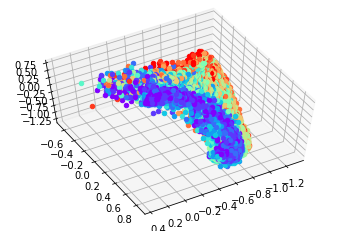

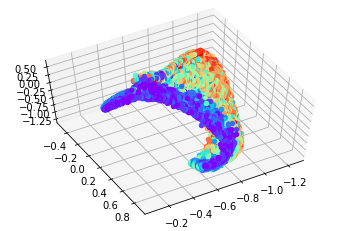

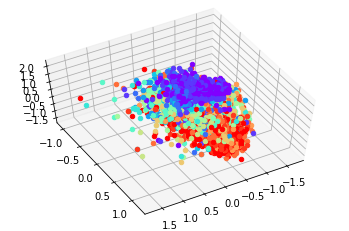

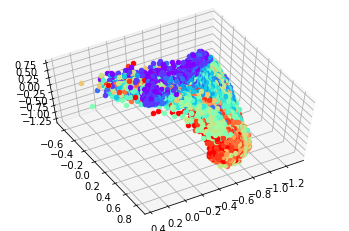

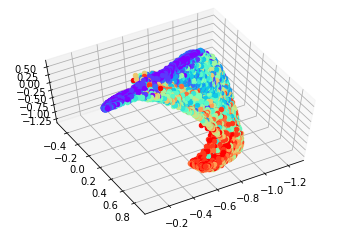

In [14]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)  

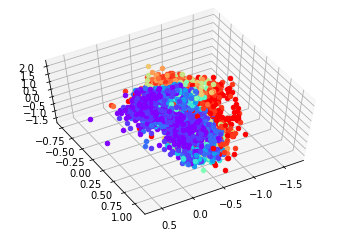

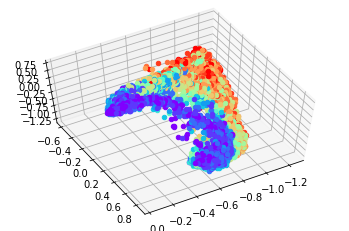

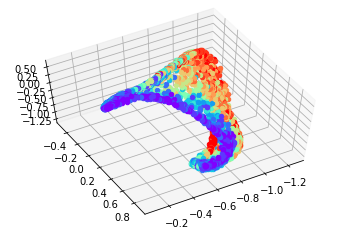

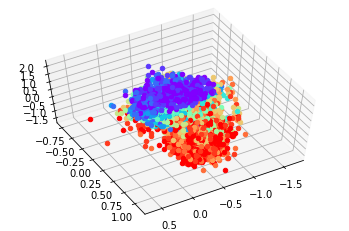

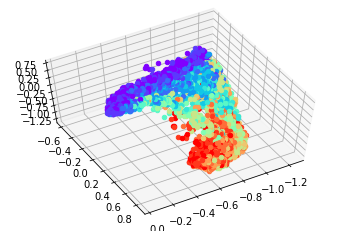

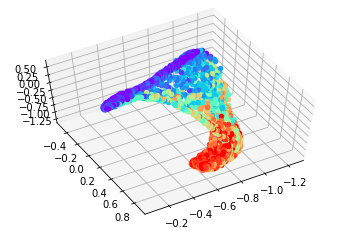

In [16]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0_2c', dpi = 400)

        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5_2c', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10_2c', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0_2c', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5_2c', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10_2c', dpi = 400)      

## separate the position graph into different stimulus groups, see if they orgnaize the same way for different stimulus, also compare after 1 2 3 cicks 

It seems that there are clearly two principle directions, but it is not certain if they overlap or there is shift between different stimulus ,  seems that for y  it is quite clear 

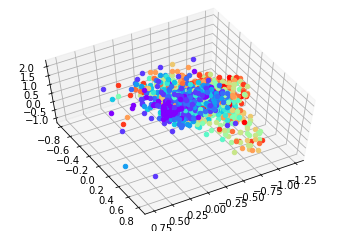

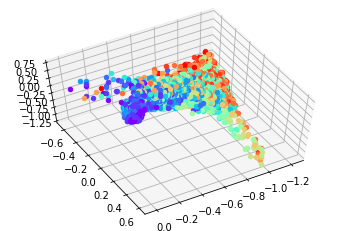

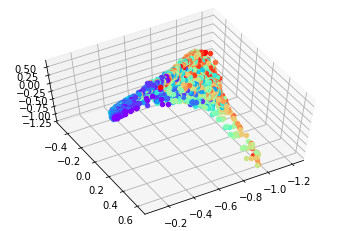

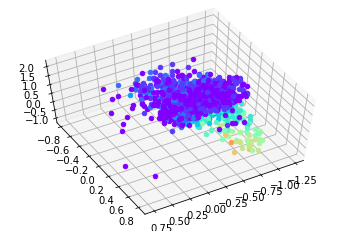

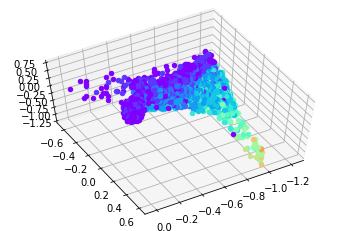

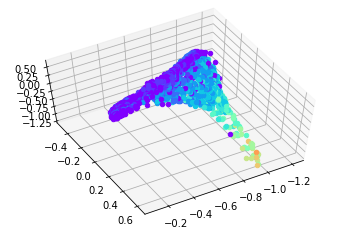

In [18]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)          

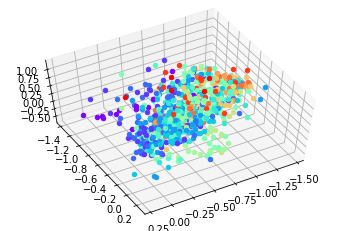

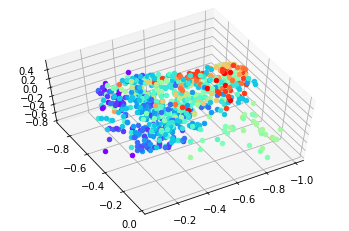

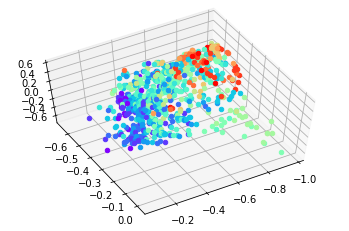

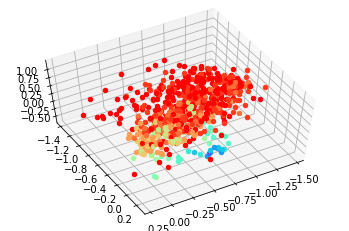

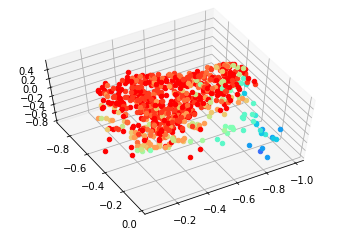

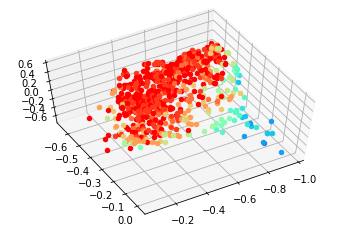

In [26]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)          

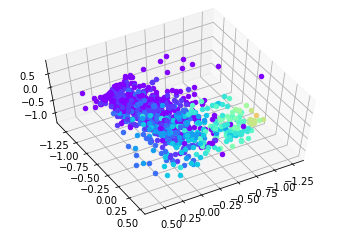

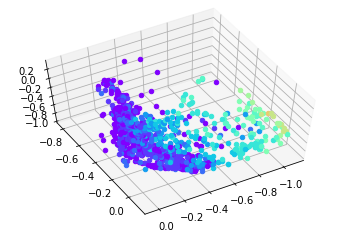

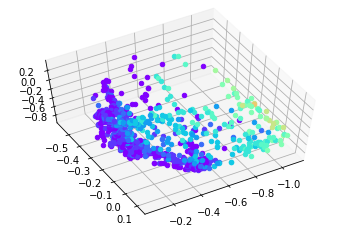

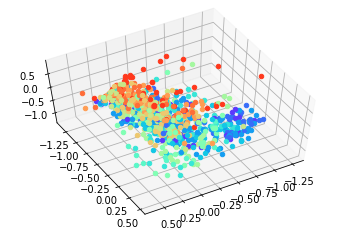

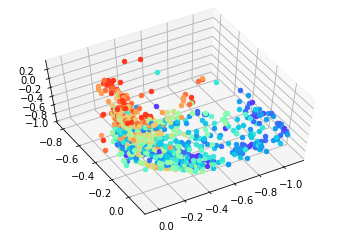

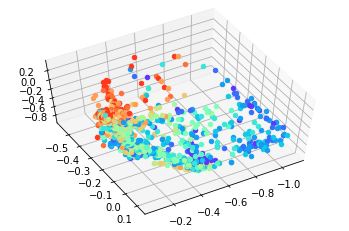

In [27]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)          

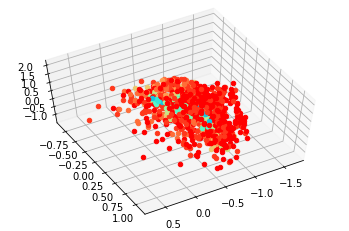

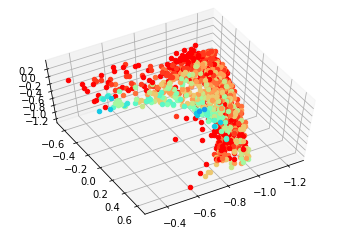

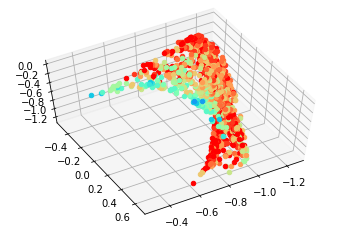

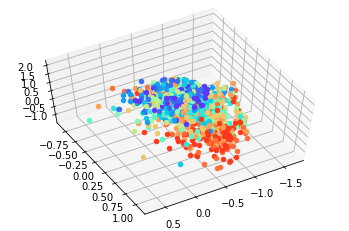

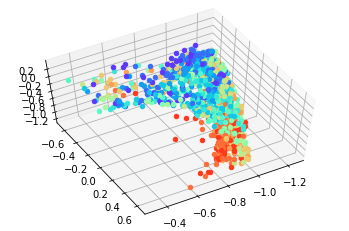

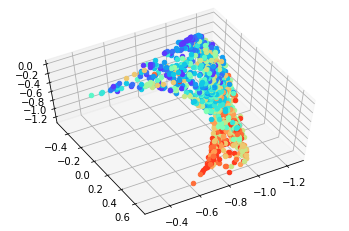

In [20]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)          

Take out the 2 cicks points 

Here for the data  prediction part

This is to see if the fit from real hidden states to position and stim could be extended to slow ponts,  seems to be wrong.

The absolute position is sliding, while the relative position kept..

**Input statistics is very important, keep the action noise small will better reveal the internal structure dynamics.  Now the question is what is relation from ring to position it is not clear, it is more like the ring is segmented by the wall not pos**

## This part anaylysis shows how the slow relaxation manifold related real game, is the geomotry relation between attractor encoded knowledge of real trace 

If the positions are well segmented, it can be shown by the knn decoder,same for stimulus, we could observe if the position decoding error and stim decoding error are correlated 


**The real game falls into the first one and two PCs quickly after cliking into the wall, means that the PC3 is a fast dimension and the other twos are slow manifold,  which we could define a plane**

In [66]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)

In [67]:
Hiddens2 = Hiddens2.transpose(1, 0, 2)

In [69]:
Hiddens2.shape

(20, 4978, 512)

In [72]:
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

### Stimulus memory decoding by KNN

In [84]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
T  = 50
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
Memory = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        memory = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
            memory.append((manifold.Status[index[0]], manifold2.Status[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)
        Memory.append(memory)

In [93]:
Right  = 0
for memory in Memory:
    right = [(m[0] == m[1]) for m in memory]
    Right += (np.sum(right)/len(right))
Right/len(Memory)

0.5147829991538064

In [3]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(300, 0, 6)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
# transform
Hiddens2 = Hiddens2.transpose(1, 0, 2)
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

In [11]:
T  = 20
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
Memory = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        memory = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
#             print (manifold2.Stages[j])
            if int(manifold2.Stages[j])>=1:
                memory.append((manifold.Status[index[0]], manifold2.Status[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)
        Memory.append(memory)

In [14]:
from sklearn.metrics import confusion_matrix 
Predicts  = []
Labels = []

for memory in Memory:
    Labels.extend([m[1] for m in memory])
    Predicts.extend([m[0] for m in memory])
#     print (memory)
Labels = np.array(Labels)
Predicts = np.array(Predicts)
confusion_matrix(Labels, Predicts)

array([[  28,   11,    3,   63,    0],
       [ 617,  444,   61,  213,    9],
       [ 191,   62,   11,   55,  374],
       [1202,  360,  188,  788,  276],
       [  29,    6,    5,    0,  191]])

In [36]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
# transform
Hiddens2 = Hiddens2.transpose(1, 0, 2)
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

In [43]:
Hiddens2.shape

(20, 5149, 512)

In [21]:
T  = 50
Memorys = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.5, T = 1)
    # attractor at different relaxation time bins
    attractors= Hiddens2[0]
    memory = []
    # points in different time of trajectory
    for j, h in enumerate(manifold2.Hiddens):
        v = attractors - h 
        index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
        if int(manifold2.Stages[j])>=1:
#             print (manifold2.Status[j], manifold2.Stages[j], manifold2.Poss[j])
            memory.append((manifold.Status[index[0]], manifold2.Status[j]))
    Memorys.append(memory)

In [22]:
# 0 term null zeros indicates reward, where status is 0 but stages are no longer 0 
from sklearn.metrics import confusion_matrix 
Predicts  = []
Labels = []

for memory in Memorys:
    Labels.extend([m[1] for m in memory])
    Predicts.extend([m[0] for m in memory])
#     print (memory)
Labels = np.array(Labels)
Predicts = np.array(Predicts)
confusion_matrix(Labels, Predicts)

array([[ 68,  13,   5,   6,  12,   4],
       [  0,   0,   0,   0,   0,   0],
       [ 11,  43, 121,   9,   3,  19],
       [  9, 104,   1, 114,  14,   6],
       [ 23,  10,   6,  14, 134,   0],
       [  1,  39,  12,   4,   0,  55]])

### Check how position decodeing depends on relaxation time,  distance to manifold, stage of exploration ,etc 

In [50]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
def estimate_position(weight, Tr = 40, k = 10, Times = 40, epsilon = 0, truncate = 500):
    Distances = []
    Distances_x = []
    Distances_y = []
    Stages = []
    Status = []
    for K in range(Times):
        manifold2 = slowmanifold(weight)
        manifold2.data_record(epsilon = epsilon, T = 1)
        distance = np.zeros((Tr, len(manifold2.Hiddens)))
        distance_x = np.zeros((Tr, len(manifold2.Hiddens)))
        distance_y = np.zeros((Tr, len(manifold2.Hiddens)))
        X = np.array([poss[1] for poss in manifold.Poss])
        X2 = np.array([poss[1] for poss in manifold2.Poss])
        Y = np.array([poss[0] for poss in manifold.Poss])
        Y2 = np.array([poss[0] for poss in manifold2.Poss])
        for tr in range(Tr):
            for i, h in enumerate(manifold2.Hiddens):
#                 attractors0 = [h for h in manifold.Hiddens]
                attractors =  Hiddens2[tr]
#                 v0 = attractors0 - h 
                v = attractors[:truncate] - h 
                distance[tr, i] = np.min(np.linalg.norm(v, axis = 1))
                index = np.argsort(np.linalg.norm(v, axis = 1))[:k]
                distance_x[tr, i] = np.abs(np.mean(X[list(index)]) - X2[i])
                distance_y[tr, i] = np.abs(np.mean(Y[list(index)]) - Y2[i])
        Distances.append(distance)
        Distances_x.append(distance_x)
        Distances_y.append(distance_y)
        Stages.append(manifold2.Stages)
        Status.append(manifold2.Status)
    return Status, Stages, Distances, Distances_x, Distances_y

In [51]:
# select later according to status for pos 
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])
Status, Stages, Distances, Distances_x, Distances_y = estimate_position(weight, Times = 500, truncate = 500)

** After getting the stages without influence of reward, the two clicks decoding now increase with relaxation, consistent with visualization **

** strong positive correlation with distance to manifold**

5.663690095347328 5.301012814257151 3.9361275493303802 500 303 103
5.7851143577575925 5.327628411345739 3.991086493952976 500 303 103
5.8070873065776585 5.329381451107398 3.898944826902535 500 303 103
5.81652174141038 5.2273630409509835 3.8121550183345696 500 303 103
5.795015272395992 5.269510438553222 3.791764320481519 500 303 103
5.726739219665048 5.356969555448148 3.7529608991924515 500 303 103
5.725312888625307 5.48231776595776 3.800047204216025 500 303 103
5.8261891251482485 5.492758967495424 3.7912902531589605 500 303 103
5.871519086989422 5.431795977308816 3.7453607285654384 500 303 103
5.934659713572218 5.394091190278811 3.715650289240719 500 303 103
5.941274164940425 5.379308869621073 3.728934841038076 500 303 103
5.947005747328797 5.388252019159795 3.776731873484858 500 303 103
5.953354604521329 5.358586646659079 3.757913811685191 500 303 103
5.957392241465367 5.269838816902149 3.705056744515248 500 303 103
5.958642540676425 5.21303728723355 3.647999071307858 500 303 103
5.95

IndexError: index 40 is out of bounds for axis 0 with size 40

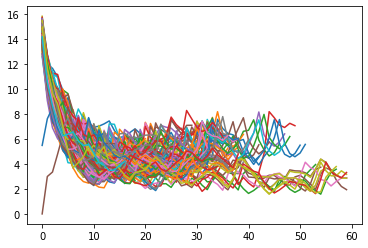

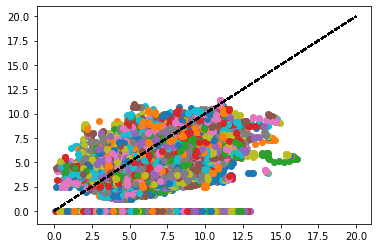

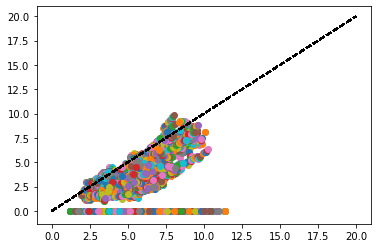

In [52]:
plt.figure(0)
for m, d in zip(Status, Distances):
    plt.plot(d[0][m != -1])
D0 = []
D1 = []
D2 = []
for k in range(50):
    E0, E1, E2 = 0, 0, 0
    k0, k1, k2 = 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * (s == 0))/(np.sum(s == 0)+1)
        errx1 = np.sum(dx * (s >=1))/(np.sum(s>=1)+1)
        errx2 = np.sum(dx * (s >=2))/(np.sum(s >=2)+1)
        erry0 = np.sum(dy * (s == 0))/(np.sum(s == 0)+1)
        erry1 = np.sum(dy * (s >=1))/(np.sum(s >=1)+1)
        erry2 = np.sum(dy * (s >=2))/(np.sum(s >=2)+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            E0 += errx0 + erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0 + erry0, errx1 + erry1)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--') 
        if errx1 + erry1 != 0:
            E1 += errx1 + erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1 + erry1, errx2 + erry2)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--')
        if errx2 + erry2 != 0:
            E2 += errx2 + erry2
            k2 += 1
    print (E0/k0, E1/k1, E2/k2, k0, k1, k2)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)

sharper difference with and without relaxation less data points

([<matplotlib.axis.XTick at 0x7fd2036b1320>,
 <a list of 20 Text xticklabel objects>)

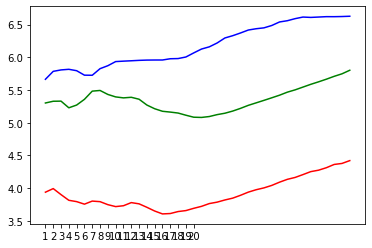

In [53]:
plt.plot(D0, 'b')
plt.plot(D1, 'g')
plt.plot(D2, 'r')
plt.xticks(list(np.arange(0,  20, 1)), list(np.arange(1, 21, 1)))

In [54]:
np.save('distance0_pos399', D0)
np.save('distance1_pos399', D1)
np.save('distance2_pos399', D1)

Text(0, 0.5, 'decoding error')

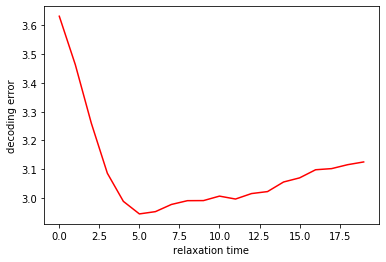

In [80]:
# another realization 
plt.plot(D2, 'r')
plt.xlabel('relaxation time')
plt.ylabel('decoding error')

Negative correlation of decoding error with distance to manifold, and decrase error after clicks, are all inverse of memnet and echo net 

The mem and echo net decode position with time collapse from stimulus, while the posnet decode from distance to manifold     

In [126]:
for K in range(3):
    distance_y = []
    distance = []
    for m, s, d, dx, dy in zip(Stages, Stages, Distances, Distances_x, Distances_y):
        if len(d[8][s >= K]) >2:
            distance.extend(d[8][(s >= K) & (m != -1)])
            distance_y.extend(dy[8][(s >= K) & (m != -1)])
    distance = np.array(distance)
    distance_y = np.array(distance_y)
    Cory = (np.corrcoef(distance, distance_y)[0][1])
    print (Cory)

0.2161865571347716
0.2774709732711368
0.17109597853385522


In [127]:
for K in range(3):
    distance_x = []
    distance = []
    for m, s, d, dx, dy in zip(Stages, Stages, Distances, Distances_x, Distances_y):
        if len(d[8][s >= K]) >2:
            distance.extend(d[8][(s >= K) & (m != -1)])
            distance_x.extend(dx[8][(s >= K) & (m != -1)])
    distance = np.array(distance)
    distance_x = np.array(distance_x)
    Corx = (np.corrcoef(distance, distance_x)[0][1])
    print (Corx)

0.35497798605852715
0.4243682174466693
0.31993267397688674


In [132]:
for K in range(3):
    Det = 0
    k = 0
    for m, s, d, dx, dy in zip(Status, Stages, Distances, Distances_x, Distances_y):
        if len(d[8][(s >= K) & (m != -1)]) >2:
            errx = dx[8][(s >= K) & (m != -1)]
            erry = dx[8][(s >= K) & (m != -1)]
            Det += (errx[int(len(errx)/2):].mean() - errx[:int(len(errx)/2)].mean()) \
            + (erry[int(len(erry)/2):].mean() - erry[:int(len(erry)/2)].mean())  
            k += 1
    print (Det/k)

-1.4885852784936788
-1.5341141028810472
-1.5518951833607006


5.521862665512599 4.020491610042473 2.9190842197018685 383 247 85
5.550564908651082 3.9063877184023608 2.859038804332922 383 247 85
5.543657383149525 3.850707878088216 2.856806556188909 383 247 85
5.495256760105388 3.838535259141021 2.796760455231044 383 247 85
5.451822146065649 3.836115657375373 2.724435965994789 383 247 85
5.48391475633518 3.8972700518674075 2.7187346574993625 383 247 85
5.503736996344796 3.9569811369898424 2.6961906981906987 383 247 85
5.621346954149099 4.01584472253392 2.760834211540095 383 247 85
5.667720321715322 4.057108484669956 2.7690920223567286 383 247 85
5.688580531427746 4.083219862833028 2.76647075800017 383 247 85
5.7045826056437505 4.073731144281411 2.7542121799768857 383 247 85
5.721689583672082 4.039499935098716 2.766550808668455 383 247 85
5.704182531183891 3.9725048246150663 2.7282810555457613 383 247 85
5.753021982536069 3.955212467301036 2.7207985576514995 383 247 85
5.811386745861008 3.9298718233600085 2.7278058314234794 383 247 85
5.841629798531

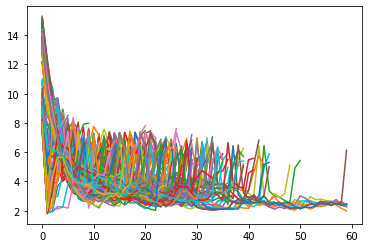

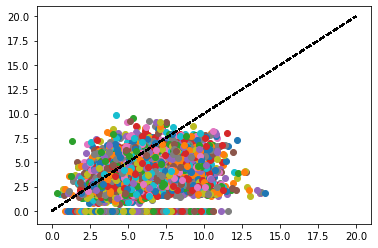

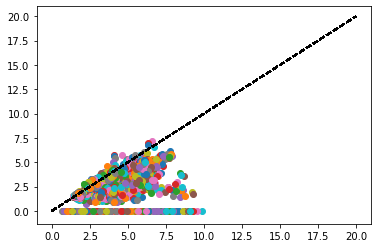

In [27]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 200)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)

plt.figure(0)
for d in Distances:
    plt.plot(d[0])
D0 = []
D1 = []
D2 = []
for k in range(20):
    E0, E1, E2 = 0, 0, 0
    k0, k1, k2 = 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * ((m != -1) & (s==0)))/(np.sum((m != -1) & (s==0))+1)
        errx1 = np.sum(dx * ((m != -1) & (s>=1)))/(np.sum((m != -1) & (s>=1))+1)
        errx2 = np.sum(dx * ((m != -1) & (s>=2)))/(np.sum((m != -1) & (s>=2))+1)
        erry0 = np.sum(dy * ((m != -1) & (s==0)))/(np.sum((m != -1) & (s==0))+1)
        erry1 = np.sum(dy * ((m != -1) & (s>=1)))/(np.sum((m != -1) & (s>=1))+1)
        erry2 = np.sum(dy * ((m != -1) & (s>=2)))/(np.sum((m != -1) & (s>=2))+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            E0 += errx0 + erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0 + erry0, errx1 + erry1)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--') 
        if errx1 + erry1 != 0:
            E1 += errx1 + erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1 + erry1, errx2 + erry2)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--')
        if errx2 + erry2 != 0:
            E2 += errx2 + erry2
            k2 += 1
    print (E0/k0, E1/k1, E2/k2, k0, k1, k2)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)

measure distance as function of decoding error, is closer to manifold, decoding error smaller 

Text(0, 0.5, 'decoding error')

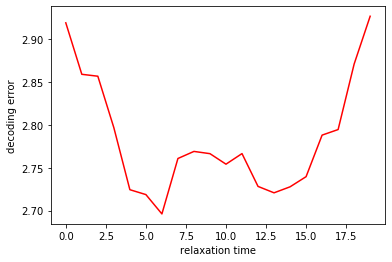

In [30]:
# plt.plot(D0, 'b')
# plt.plot(D1, 'g')
plt.plot(D2, 'r')
plt.xlabel('relaxation time')
plt.ylabel('decoding error')

### Check for decoding accuracy of each position conditioned on stimulus memory, in order to see if there are any bias.  

This analysis is to reveal after each clck if it only remembers position related to the wall, or it is a 2D objects which related to both.     

3.3448860878206146 1.4917112140786697 2.707258649159517 2.314137534913666 2.2857082149993797 2.336888307023748 1.752023966814614 1.716478631813424
2.952022775527335 1.8485304782453755 2.6462806509982104 2.649311269697009 2.321665313793628 2.3802127339819013 2.115836140294726 1.659343704148701
2.666195707976257 2.0480070975209888 2.7625705980403525 2.7581073307583663 2.087589753558821 2.445335730559404 2.172149948713377 1.601095912024442
2.548153433349674 2.1381477961366495 2.6689733301842344 2.2269688411314967 1.9343809962675962 2.5177686430930537 2.2398845047668847 1.5212119061668
2.4367685392726557 2.3280686593345354 2.663388068177065 1.964771559044445 1.8113498840569895 2.6422744569314047 2.0702415552882734 1.5263396458033767
2.3679619566794363 2.194003905643262 2.319151781669579 1.9868698320700833 1.6489941917407058 2.7420268642490178 1.931559094225684 1.5587565808613117
2.4480143650178285 2.041629050766414 2.2298157741286326 1.9442751093237864 1.4242991669525098 2.864781341879694 

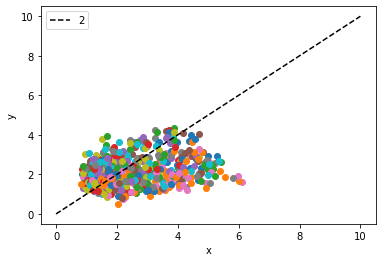

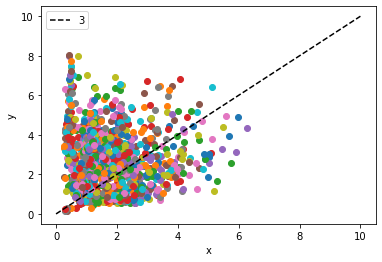

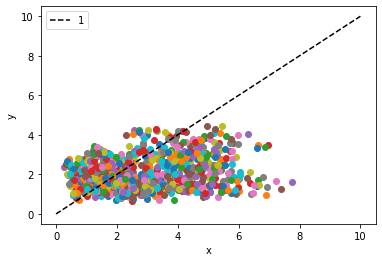

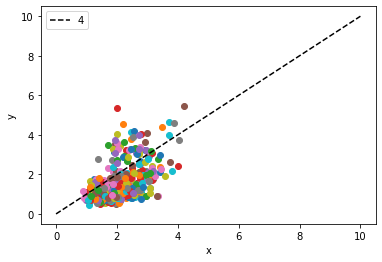

In [166]:
D0 = []
D1 = []
D2 = []
for k in np.arange(0, 20, 2):
    Ex0, Ex1, Ex2, Ex3 = 0, 0, 0, 0
    Ey0, Ey1, Ey2, Ey3 = 0, 0, 0, 0
    k0, k1, k2, k3 = 0, 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * (m == 1))/(np.sum(m == 1)+1)
        errx1 = np.sum(dx * (m == 2))/(np.sum(m == 2)+1)
        errx2 = np.sum(dx * (m == 3))/(np.sum(m == 3)+1)
        errx3 = np.sum(dx * (m == 4))/(np.sum(m == 4)+1)
        erry0 = np.sum(dy * (m == 1))/(np.sum(m == 1)+1)
        erry1 = np.sum(dy * (m == 2))/(np.sum(m == 2)+1)
        erry2 = np.sum(dy * (m == 3))/(np.sum(m == 3)+1)
        erry3 = np.sum(dy * (m == 4))/(np.sum(m == 4)+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            Ex0 += errx0
            Ey0 += erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0, erry0)
     
        if errx1 + erry1 != 0:
            Ex1 += errx1
            Ey1 += erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1, erry1)
        if errx2 + erry2 != 0:
            Ex2 += errx2 
            Ey2 += erry2
            k2 += 1
            plt.figure(3)
            plt.scatter(errx2, erry2)

        if errx3 + erry3 != 0:
            Ex3 += errx3 
            Ey3 += erry3
            k3 += 1
            plt.figure(4)
            plt.scatter(errx3, erry3)
          
    print (Ex0/k0, Ey0/k0, Ex1/k1, Ey1/k1, Ex2/k2, Ey2/k2, Ex3/k3, Ey3/k3)
for k in np.arange(1, 5, 1):
    plt.figure(k)
    plt.plot(np.linspace(0, 10, 100), np.linspace(0, 10,  100), 'k--', label = k) 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

After two clicks, it could be shown that for each memory state there is good decoding of both x, y, suggesting a plane attractors behind, the next question will be, if we write 
x = k1 PC1 + k2PC2, or PC = k1x + k2y, are the coefcient based on different history same or different  

3.0335109126984117 0.717642857142857 3.521323802460165 1.9569345301163479 1.2261742424242423 2.0466287878787877 1.395292624042624 1.3390401265401266
2.680078373015873 0.889224206349206 3.3403159592932328 2.1653460680733403 1.1390873015873015 2.1466107503607503 1.4454899267399266 1.2897947885447885
2.38145734126984 1.0704424603174603 3.0815737923692477 2.38404563870473 1.2233964646464646 2.163293650793651 1.5611371961371963 1.1793027805527805
2.1998025793650795 1.1934444444444448 3.0446258539440354 2.483302820916457 1.1756890331890333 2.2333170995670995 1.57996336996337 1.1158641358641357
1.991127976190476 1.2124662698412698 3.082935461003643 2.5484049662458754 1.209332611832612 2.084825036075036 1.5107742257742258 1.1054820179820182
1.9249216269841274 1.2226795634920637 2.9651840709795256 2.394137264250901 1.1554076479076478 1.9928012265512265 1.5486896436896436 1.043967282717283
1.8832678571428567 1.272407738095238 2.8355563880563883 2.13673297661934 1.1947835497835497 1.9688906926406

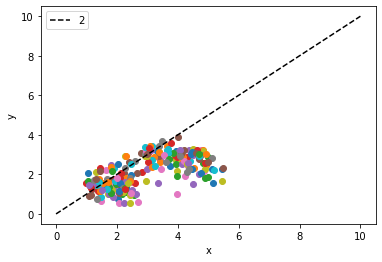

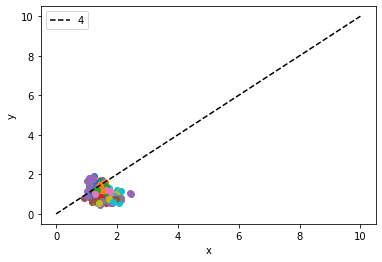

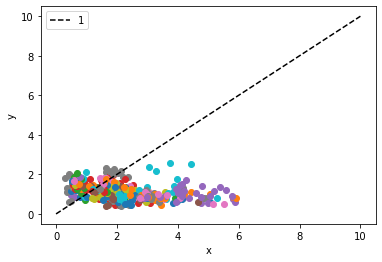

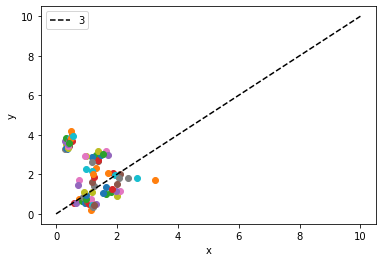

In [167]:
D0 = []
D1 = []
D2 = []
for k in range(10):
    Ex0, Ex1, Ex2, Ex3 = 0, 0, 0, 0
    Ey0, Ey1, Ey2, Ey3 = 0, 0, 0, 0
    k0, k1, k2, k3 = 0, 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        errx1 = np.sum(dx * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        errx2 = np.sum(dx * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        errx3 = np.sum(dx * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
        erry0 = np.sum(dy * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        erry1 = np.sum(dy * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        erry2 = np.sum(dy * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        erry3 = np.sum(dy * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            Ex0 += errx0
            Ey0 += erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0, erry0)
     
        if errx1 + erry1 != 0:
            Ex1 += errx1
            Ey1 += erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1, erry1)
        if errx2 + erry2 != 0:
            Ex2 += errx2 
            Ey2 += erry2
            k2 += 1
            plt.figure(3)
            plt.scatter(errx2, erry2)

        if errx3 + erry3 != 0:
            Ex3 += errx3 
            Ey3 += erry3
            k3 += 1
            plt.figure(4)
            plt.scatter(errx3, erry3)
          
    print (Ex0/k0, Ey0/k0, Ex1/k1, Ey1/k1, Ex2/k2, Ey2/k2, Ex3/k3, Ey3/k3)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)
for k in np.arange(1, 5, 1):
    plt.figure(k)
    plt.plot(np.linspace(0, 10, 100), np.linspace(0, 10,  100), 'k--', label = k) 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

With more noise, the memory of second last stimulus related position becomes weaker,  revealed by shape of scatter plot. 

The trends of decoding error with relaxation times is the same.  The relaxatin is favorable to second last stimulus memory position, but detrimental to new state memory related position 

It is also partially related to pretraining process itself.

**The observation of stimulus memory error is clearly correlated with position decoding, the better stimlus memory , larger diffrence between x and y decoding
**

## construct h = f(x, y, s) 
Explore hs = k1x + k2y + b 
is k1, k2, b same ?  
In order to see if each stimulus has the same or differen spatial map,  we use hiddens of all recordings, split into four stimulus, use the linear regression to map each of them 

**The answer is there are three correlated maps, the s3 s4 for left right wall is kind of single map, while s1 and s2 are rather separted to all, revealed by the intercept value, while k1 and k2 are quit correlated for all pairs**

In [3]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 200)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)

In [4]:
Hiddens2 = Hiddens2.transpose(1, 0 ,2)

In [6]:
for k in range(5):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 1) & (s>=2)]
        xs = x[(m == 1) & (s>=2)]
        ys = y[(m == 1) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf1 = sklearn.linear_model.LinearRegression()
    clf1.fit(Pos, PCs)
    print (clf1.coef_, clf1.intercept_)

[[-0.05273727 -0.05753187]
 [ 0.03664733  0.01865103]
 [-0.03970762 -0.01464674]] [ 1.77498329 -1.52340039  0.32753059]
[[-0.04647579 -0.06749106]
 [ 0.01991016  0.01954576]
 [-0.03429777 -0.0271252 ]] [ 1.69636622 -1.3718088   0.23998592]
[[-0.03972807 -0.07016407]
 [ 0.03035448  0.02358965]
 [-0.03948441 -0.02100584]] [ 1.68935729 -1.57568498  0.19760817]
[[-0.03827597 -0.07276737]
 [ 0.0350455   0.02362251]
 [-0.04166635 -0.01620425]] [ 1.67858587 -1.6486383   0.15872398]
[[-0.03755816 -0.07548078]
 [ 0.03728267  0.02377835]
 [-0.04380696 -0.01450523]] [ 1.6817696  -1.68850298  0.16066082]


In [6]:
np.dot(clf1.coef_[:, 0], clf1.coef_[:, 1])/(np.linalg.norm(clf1.coef_[:, 0]) * np.linalg.norm(clf1.coef_[:, 1]))

0.18077575412592659

In [7]:
for k in range(5):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 2) & (s>=2)]
        xs = x[(m == 2) & (s>=2)]
        ys = y[(m == 2) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf2 = sklearn.linear_model.LinearRegression()
    clf2.fit(Pos, PCs)
    print (clf2.coef_, clf2.intercept_)

[[-0.05288891 -0.05866067]
 [ 0.03295661  0.0186365 ]
 [-0.03852184 -0.01777624]] [ 1.79653411 -1.47577816  0.385165  ]
[[-0.04868122 -0.06918083]
 [ 0.02452758  0.02526323]
 [-0.03533676 -0.03519227]] [ 1.76166944 -1.46329371  0.35843459]
[[-0.04127757 -0.06716621]
 [ 0.030378    0.02795761]
 [-0.04181976 -0.03043665]] [ 1.69376053 -1.61035936  0.34284985]
[[-0.04104908 -0.07017821]
 [ 0.03415121  0.02611278]
 [-0.0462694  -0.02587438]] [ 1.69396011 -1.65300182  0.32746992]
[[-0.04125551 -0.07393292]
 [ 0.03551699  0.02502738]
 [-0.04879648 -0.02407688]] [ 1.70947914 -1.66463176  0.33074943]


In [8]:
np.dot(clf2.coef_[:, 0], clf2.coef_[:, 1])/(np.linalg.norm(clf2.coef_[:, 0]) * np.linalg.norm(clf2.coef_[:, 1]))

0.13200783421571416

In [8]:
for k in range(5):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 3) & (s>=2)]
        xs = x[(m == 3) & (s>=2)]
        ys = y[(m == 3) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf3 = sklearn.linear_model.LinearRegression()
    clf3.fit(Pos, PCs)
    print (clf3.coef_, clf3.intercept_)

[[-0.05666866 -0.09480677]
 [ 0.04806021  0.03673021]
 [-0.04456705 -0.02819487]] [ 2.1670219  -1.92719584  0.55758221]
[[-0.05512302 -0.11004835]
 [ 0.03687436  0.04588039]
 [-0.03973214 -0.04377558]] [ 2.19495516 -1.8969836   0.50879789]
[[-0.05302294 -0.11419762]
 [ 0.04271022  0.05111259]
 [-0.04598343 -0.04040636]] [ 2.22668687 -2.06208608  0.50263776]
[[-0.0529935  -0.11823596]
 [ 0.04636628  0.051322  ]
 [-0.05064657 -0.03735714]] [ 2.23853633 -2.11637906  0.49551155]
[[-0.05352093 -0.12221839]
 [ 0.04766754  0.05197639]
 [-0.05241479 -0.03697991]] [ 2.25888483 -2.13769471  0.49399662]


In [10]:
np.dot(clf3.coef_[:, 0], clf3.coef_[:, 1])/(np.linalg.norm(clf3.coef_[:, 0]) * np.linalg.norm(clf3.coef_[:, 1]))

0.29831457511403286

In [9]:
for k in range(5):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 4) & (s>=2)]
        xs = x[(m == 4) & (s>=2)]
        ys = y[(m == 4) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf4 = sklearn.linear_model.LinearRegression()
    clf4.fit(Pos, PCs)
    print (clf4.coef_, clf4.intercept_)

[[-0.0567021  -0.09002726]
 [ 0.0418677   0.0224986 ]
 [-0.0457662  -0.04186195]] [ 2.07961765 -1.66693588  0.71172118]
[[-0.06217428 -0.10720102]
 [ 0.03637259  0.03579587]
 [-0.04326253 -0.05395286]] [ 2.20182218 -1.75124975  0.6624112 ]
[[-0.06178785 -0.1125881 ]
 [ 0.03914134  0.04149585]
 [-0.05028765 -0.0464674 ]] [ 2.25849043 -1.89170979  0.62355095]
[[-0.06360514 -0.11628717]
 [ 0.04173069  0.04085423]
 [-0.0554001  -0.04050035]] [ 2.28607773 -1.92556474  0.59553615]
[[-0.06534964 -0.11982136]
 [ 0.0428288   0.04086728]
 [-0.057507   -0.0389263 ]] [ 2.3158979  -1.93823852  0.58976795]


In [12]:
np.dot(clf4.coef_[:, 0], clf4.coef_[:, 1])/(np.linalg.norm(clf4.coef_[:, 0]) * np.linalg.norm(clf4.coef_[:, 1]))

0.14033203760137566

In [13]:
print (np.dot(clf1.coef_[:, 0], clf2.coef_[:, 0])/(np.linalg.norm(clf1.coef_[:, 0]) * np.linalg.norm(clf2.coef_[:, 0])))
print (np.dot(clf1.coef_[:, 0], clf3.coef_[:, 0])/(np.linalg.norm(clf1.coef_[:, 0]) * np.linalg.norm(clf3.coef_[:, 0])))
print (np.dot(clf1.coef_[:, 0], clf4.coef_[:, 0])/(np.linalg.norm(clf1.coef_[:, 0]) * np.linalg.norm(clf4.coef_[:, 0])))
print (np.dot(clf2.coef_[:, 0], clf3.coef_[:, 0])/(np.linalg.norm(clf2.coef_[:, 0]) * np.linalg.norm(clf3.coef_[:, 0])))
print (np.dot(clf2.coef_[:, 0], clf4.coef_[:, 0])/(np.linalg.norm(clf2.coef_[:, 0]) * np.linalg.norm(clf4.coef_[:, 0])))
print (np.dot(clf3.coef_[:, 0], clf4.coef_[:, 0])/(np.linalg.norm(clf3.coef_[:, 0]) * np.linalg.norm(clf4.coef_[:, 0])))

0.9997230928238953
0.9716779618284677
0.9895617978553582
0.9737543153508469
0.9920386757042217
0.9912427877631


In [14]:
print (np.dot(clf1.coef_[:, 1], clf2.coef_[:, 1])/(np.linalg.norm(clf1.coef_[:, 1]) * np.linalg.norm(clf2.coef_[:, 1])))
print (np.dot(clf1.coef_[:, 1], clf3.coef_[:, 1])/(np.linalg.norm(clf1.coef_[:, 1]) * np.linalg.norm(clf3.coef_[:, 1])))
print (np.dot(clf1.coef_[:, 1], clf4.coef_[:, 1])/(np.linalg.norm(clf1.coef_[:, 1]) * np.linalg.norm(clf4.coef_[:, 1])))
print (np.dot(clf2.coef_[:, 1], clf3.coef_[:, 1])/(np.linalg.norm(clf2.coef_[:, 1]) * np.linalg.norm(clf3.coef_[:, 1])))
print (np.dot(clf2.coef_[:, 1], clf4.coef_[:, 1])/(np.linalg.norm(clf2.coef_[:, 1]) * np.linalg.norm(clf4.coef_[:, 1])))
print (np.dot(clf3.coef_[:, 1], clf4.coef_[:, 1])/(np.linalg.norm(clf3.coef_[:, 1]) * np.linalg.norm(clf4.coef_[:, 1])))

0.964442919374557
0.9747254065617288
0.9199206300156847
0.9964108947663582
0.988119899019757
0.9840292404030261


In [31]:
# Visualizing with 3d plot
PC1 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC1[k, i, j] = clf1.coef_[k, 0] * x + clf1.coef_[k, 1] * y + clf1.intercept_[k]

PC2 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC2[k, i, j] = clf2.coef_[k, 0] * x + clf2.coef_[k, 1] * y + clf2.intercept_[k]
            
PC3 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC3[k, i, j] = clf3.coef_[k, 0] * x + clf3.coef_[k, 1] * y + clf3.intercept_[k]
            

PC4 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC4[k, i, j] = clf4.coef_[k, 0] * x + clf4.coef_[k, 1] * y + clf4.intercept_[k]

In [32]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 5)
manifold2 = slowmanifold(weight)
manifold2.data_record(epsilon = 0.0,  T = 1)

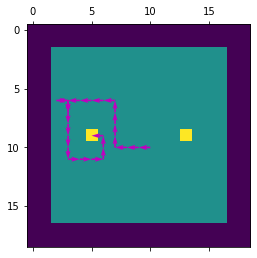

In [33]:
grid = manifold2.pca.game.grid.grid.copy()
plt.matshow(grid)
Pos = manifold2.Poss
y = np.array([p[0] for p in Pos])
x = np.array([p[1] for p in Pos])
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color = 'm')

In [34]:
colors = ['k', 'r', 'g', 'b', 'c']
pc0 = np.dot(manifold2.Hiddens, manifold.pca.vect[0])
pc1 = np.dot(manifold2.Hiddens, manifold.pca.vect[1])
pc2 = np.dot(manifold2.Hiddens, manifold.pca.vect[2])

U = pc0[1:] - pc0[:-1]
V = pc1[1:] - pc1[:-1]
W = pc2[1:] - pc2[:-1]
colors_s = [colors[s] for s in manifold2.Status]
colors_a = [colors[s] for s in manifold2.Actions]


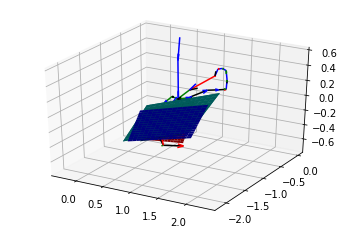

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_a)

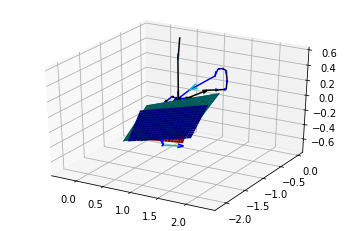

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

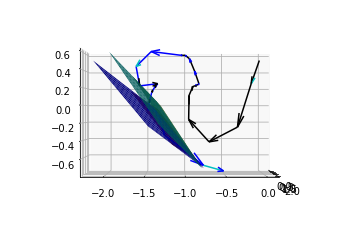

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 0)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

Text(0.5, 0, 'pc1')

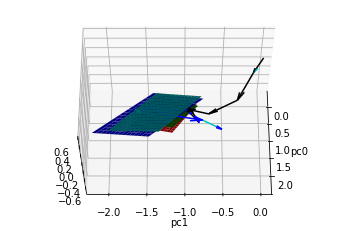

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(60, 0)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)
plt.xlabel('pc0')
plt.ylabel('pc1')


The classification rate on blue stimulus is actually highest   

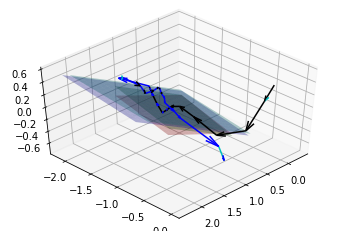

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, 45)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r', alpha = 0.3)
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g', alpha = 0.3)
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b', alpha = 0.3)
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c', alpha = 0.3)
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

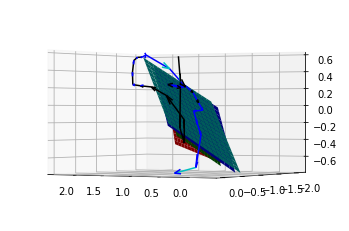

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 120)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

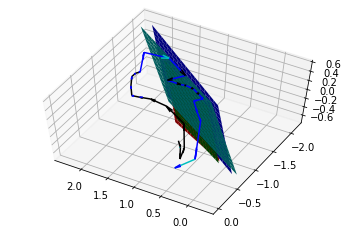

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(60, 120)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

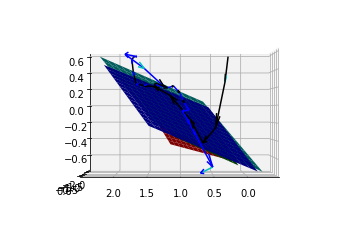

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 90)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')
ax.quiver(pc0[:-1], pc1[:-1], pc2[:-1], U, V, W, color = colors_s)

In [352]:
## calculate participation ratio
Cor = np.zeros((512, 512))
for h in Hiddens2[-1]:
    h = (h - np.mean(h))/np.std(h)
    h = h.reshape(1, 512)
    Cor += h.T @ h 
print (Cor)
lambdas, vs = np.linalg.eig(Cor)
np.sum(lambdas) ** 2/np.sum(lambdas** 2)

[[ 7539.96291668 -1512.2220207   2114.50370387 ... -1244.72578937
   7733.74425699  1694.95304508]
 [-1512.2220207   6457.57116292   511.44444623 ... -2196.42302195
  -6630.49970548  2420.69931005]
 [ 2114.50370387   511.44444623  4258.47599786 ...  3629.54061609
   1092.95918378 -2721.95380023]
 ...
 [-1244.72578937 -2196.42302195  3629.54061609 ...  8723.28562761
  -1040.45335993 -6962.42605322]
 [ 7733.74425699 -6630.49970548  1092.95918378 ... -1040.45335993
  14105.08713943   774.66073466]
 [ 1694.95304508  2420.69931005 -2721.95380023 ... -6962.42605322
    774.66073466  6161.85362603]]


1.9160530229754622

### look at relation between q learning readout and manifold

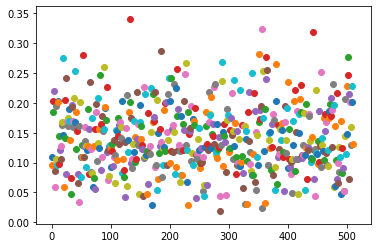

In [335]:
v = torch.load('weights_basic_pos2/rnn_1515tanh512_checkpoint399_0_5')['h2o'].data.numpy()
for k, vect in enumerate(vs[:512]):
    norm = 0
    for i in range(4):
        norm += np.sum(np.abs(np.dot(v[:, i], vect)/(np.linalg.norm(vect) * np.linalg.norm(v[:, i]))))
    plt.scatter(k, norm)

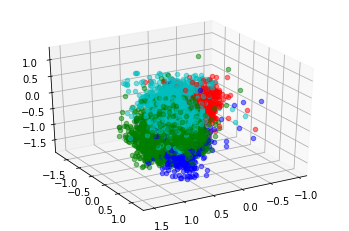

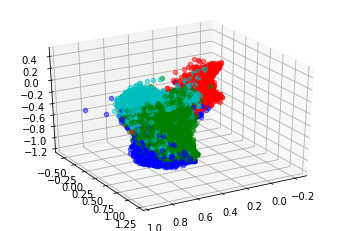

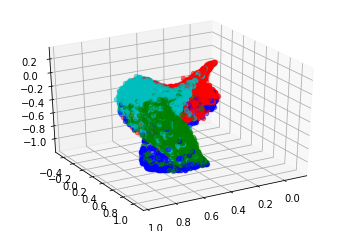

In [63]:
# no coloring on velocity   
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(30, 60)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)

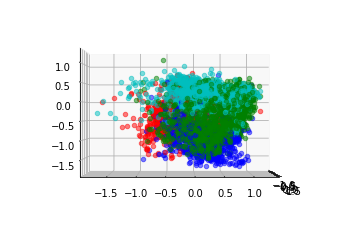

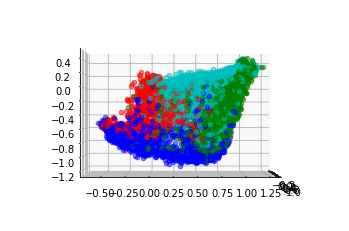

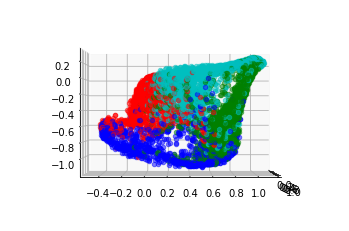

In [64]:
# no coloring on velocity   
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(0, 0)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)

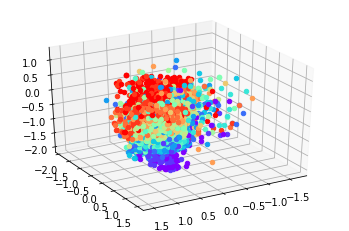

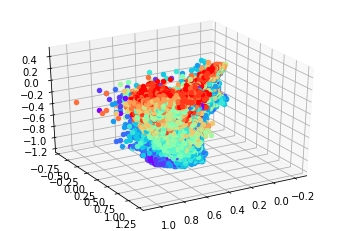

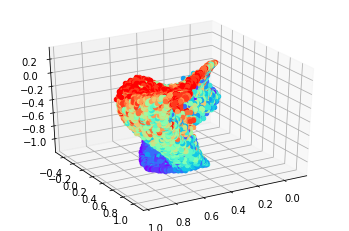

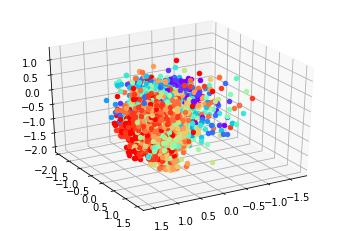

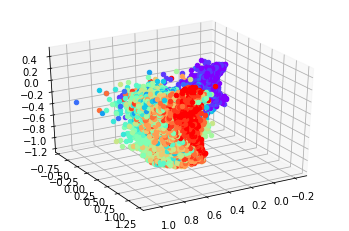

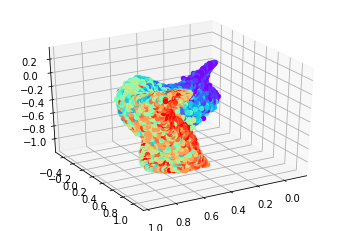

In [61]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[X == x]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][X == x]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][X == x]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[Y == y]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][Y == y]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][Y == y]):
#         plt.figure(0)
        ax.view_init(30, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)  

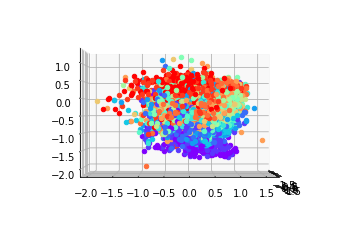

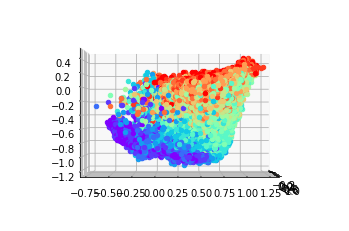

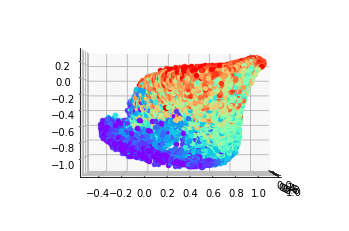

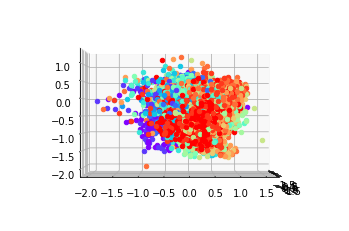

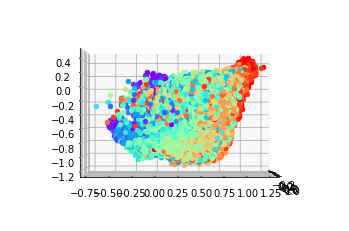

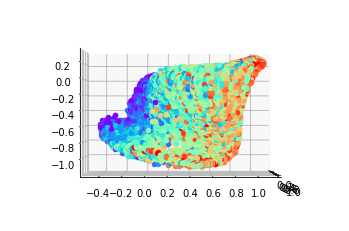

In [65]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[X == x]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][X == x]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][X == x]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[Y == y]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][Y == y]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][Y == y]):
#         plt.figure(0)
        ax.view_init(0, 0)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)  

In [11]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
Hiddens2 = Hiddens2.transpose(1, 0 ,2)
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 1) & (s>=2)]
        xs = x[(m == 1) & (s>=2)]
        ys = y[(m == 1) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf1 = sklearn.linear_model.LinearRegression()
    clf1.fit(Pos, PCs)
print (clf1.coef_, clf1.intercept_)
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 2) & (s>=2)]
        xs = x[(m == 2) & (s>=2)]
        ys = y[(m == 2) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf2 = sklearn.linear_model.LinearRegression()
    clf2.fit(Pos, PCs)
print (clf2.coef_, clf2.intercept_)
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 3) & (s>=2)]
        xs = x[(m == 3) & (s>=2)]
        ys = y[(m == 3) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf3 = sklearn.linear_model.LinearRegression()
    clf3.fit(Pos, PCs)
print (clf3.coef_, clf3.intercept_)    
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 4) & (s>=2)]
        xs = x[(m == 4) & (s>=2)]
        ys = y[(m == 4) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf4 = sklearn.linear_model.LinearRegression()
    clf4.fit(Pos, PCs)
print (clf4.coef_, clf4.intercept_)

# Visualizing with 3d plot
PC1 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC1[k, i, j] = clf1.coef_[k, 0] * x + clf1.coef_[k, 1] * y + clf1.intercept_[k]

PC2 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC2[k, i, j] = clf2.coef_[k, 0] * x + clf2.coef_[k, 1] * y + clf2.intercept_[k]
            
PC3 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC3[k, i, j] = clf3.coef_[k, 0] * x + clf3.coef_[k, 1] * y + clf3.intercept_[k]
            

PC4 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC4[k, i, j] = clf4.coef_[k, 0] * x + clf4.coef_[k, 1] * y + clf4.intercept_[k]

[[ 0.01315728  0.00677606]
 [-0.02104577 -0.02238627]
 [-0.04590973 -0.03172892]] [0.44178824 0.18242942 0.42829335]
[[ 0.02402369  0.01369205]
 [-0.02234401 -0.024788  ]
 [-0.05223221 -0.03796606]] [0.26866394 0.24211849 0.6443813 ]
[[ 0.01710141  0.0174439 ]
 [-0.02193179 -0.03269801]
 [-0.05437529 -0.04435865]] [0.41529913 0.25248758 0.63314037]
[[ 0.00387258  0.02231042]
 [-0.01187799 -0.03463018]
 [-0.03867199 -0.03648098]] [0.30560513 0.24179702 0.4333685 ]


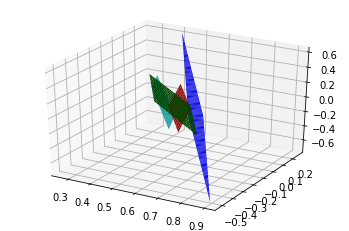

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

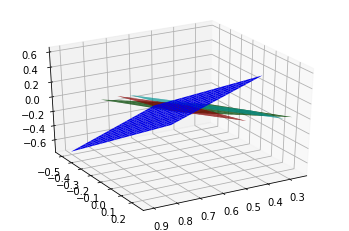

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

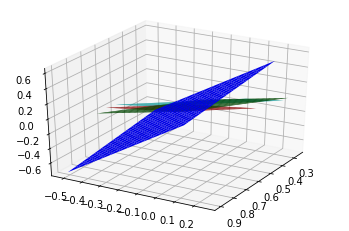

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 30)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

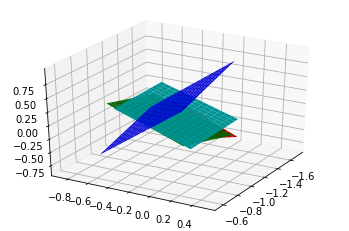

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 30)
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

In [4]:
weight = 'weights_pos2/rnn_1515tanh512_checkpoint{}'.format(300)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
Hiddens2 = Hiddens2.transpose(1, 0 ,2)
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 1) & (s>=2)]
        xs = x[(m == 1) & (s>=2)]
        ys = y[(m == 1) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf1 = sklearn.linear_model.LinearRegression()
    clf1.fit(Pos, PCs)
print (clf1.coef_, clf1.intercept_)
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 2) & (s>=2)]
        xs = x[(m == 2) & (s>=2)]
        ys = y[(m == 2) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf2 = sklearn.linear_model.LinearRegression()
    clf2.fit(Pos, PCs)
print (clf2.coef_, clf2.intercept_)
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 3) & (s>=2)]
        xs = x[(m == 3) & (s>=2)]
        ys = y[(m == 3) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf3 = sklearn.linear_model.LinearRegression()
    clf3.fit(Pos, PCs)
print (clf3.coef_, clf3.intercept_)    
    
for k in range(2):
    X = np.array([poss[1] for poss in manifold.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])

    PCs = []
    Xs = []
    Ys = []
    for H, s, m, x, y in zip(Hiddens2[4 * k], manifold.Status, manifold.Stages, X, Y):
        Hs = H[(m == 4) & (s>=2)]
        xs = x[(m == 4) & (s>=2)]
        ys = y[(m == 4) & (s>=2)]
        PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
        Xs.extend(xs)
        Ys.extend(ys)

    PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
    Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
#     print (Pos.shape, PCs.shape)

    clf4 = sklearn.linear_model.LinearRegression()
    clf4.fit(Pos, PCs)
print (clf4.coef_, clf4.intercept_)

# Visualizing with 3d plot
PC1 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC1[k, i, j] = clf1.coef_[k, 0] * x + clf1.coef_[k, 1] * y + clf1.intercept_[k]

PC2 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC2[k, i, j] = clf2.coef_[k, 0] * x + clf2.coef_[k, 1] * y + clf2.intercept_[k]
            
PC3 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(3):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC3[k, i, j] = clf3.coef_[k, 0] * x + clf3.coef_[k, 1] * y + clf3.intercept_[k]
            

PC4 = np.zeros((3, 15, 15))
x = np.arange(0, 15, 1)
y = np.arange(0, 15, 1)
xx, yy = np.meshgrid(x, y)
for k in range(2):
    for i in range(len(xx)):
        for j, (x, y) in enumerate(zip(xx[i], yy[i])):
            PC4[k, i, j] = clf4.coef_[k, 0] * x + clf4.coef_[k, 1] * y + clf4.intercept_[k]

[[ 0.0074194   0.00673776]
 [-0.01758363  0.08036015]
 [ 0.06288496  0.00702234]] [ 0.65330339 -0.87572529 -1.33974433]
[[ 0.02591389  0.02318562]
 [-0.02327671  0.11933215]
 [ 0.06556851 -0.0135357 ]] [ 0.24800952 -1.19357734 -1.30536618]
[[ 0.02880059  0.04569981]
 [ 0.01125261  0.13921237]
 [ 0.05509583 -0.02849384]] [-0.13330816 -1.86742594 -0.87550613]
[[ 0.03113686  0.04188827]
 [-0.00240631  0.1451852 ]
 [ 0.05604014 -0.03436007]] [-0.11700288 -1.89953686 -0.7765763 ]


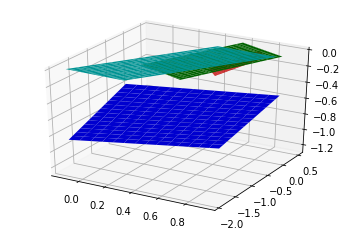

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(PC1[0], PC1[1], PC1[2], color = 'r')
ax.plot_surface(PC2[0], PC2[1], PC2[2], color = 'g')
ax.plot_surface(PC3[0], PC3[1], PC3[2], color = 'b')
ax.plot_surface(PC4[0], PC4[1], PC4[2], color = 'c')

### Summary

**0 The strategy is directly reflecting the internal dynamics**

**1 The ability to model the external world lies in richness of internal dynamics, for example the distribution of timescales forms during the pretraining**

**2 To characterize the rich internal timescales , there are 5 features, 1,  the ratio limit cycle/fix point 2,  the mean of relaxation time to fix point 3, the variance of relaxation timescale to fix point  4, the distribution of timescales of limit cycles 5,  The multi-stablity from stimulus**

**3 The performance are : extrapolation performance(small, large),  intrapolation performance(small , middle , large),  learning speed, learning stability,  Try to to connect the 5 features of dynamics to the performance metrix**

**4, Until now ratio limit cycle/fix point during the close loop form seems to indicates best the performance but with noise.**  


**what is the relation between close loop and open loop analysis?**

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**